In [1]:
import numpy as np
from qiskit import BasicAer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from qiskit.opflow import X, Z, I
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

from qiskit.utils import algorithm_globals
seed = 50
algorithm_globals.random_seed = seed
ql = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
opt = SLSQP(maxiter=10000)
vqe = VQE(ansatz=ansatz, optimizer=opt, quantum_instance=ql, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(H2_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 65,
    'eigenstate': array([ 9.54998859e-05+2.98234338e-16j, -9.93766275e-01-7.35755577e-16j,
        1.11483549e-01+2.60562039e-16j,  1.77240156e-05+7.05233587e-17j]),
    'eigenvalue': (-1.8572750175659285+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[5]): 1.5683259885445988,
                              ParameterVectorElement(θ[7]): 0.36020722970466373,
                              ParameterVectorElement(θ[6]): -4.717618122820399,
                              ParameterVectorElement(θ[0]): 4.296520309146017,
                              ParameterVectorElement(θ[4]): -2.5983258651155454,
                              ParameterVectorElement(θ[3]): 6.092947776896387,
                              ParameterVectorElement(θ[2]): 0.5470753589336304,
                              ParameterVectorElement(θ[1]): 4.426962084521693},
    'optimal_point': array([ 4.29652031,  4.42696208,  0.54707536,  6.09294778, -

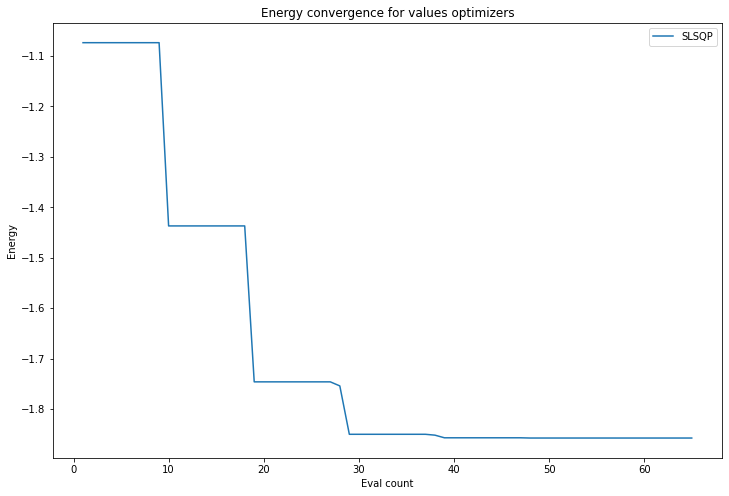

In [2]:
import pylab as pl
pl.rcParams['figure.figsize'] = (12, 8)
pl.plot(counts, values, label='SLSQP')
pl.xlabel('Eval count')
pl.ylabel('Energy')
pl.title('Energy convergence for values optimizers')
pl.legend(loc='upper right')


In [5]:
from scipy.linalg import expm
import numpy.linalg as LA
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Y, Z, I
def create_hamiltonian(Nq, cn, gamma, Bn):
    '''
    create Hamiltonian gate
    target Hamiltonian is H=1/2*cn((1+gamma)XX+(1-gamma)YY)+BnZn
    Nq -> number of qubit
    cn -> coupling constant
    gamma -> parameter
    Bn -> Magnetic field
    '''
    
    XX= np.array(np.zeros(2**Nq))
    YY= np.array(np.zeros(2**Nq))
    Zn= np.array(np.zeros(2**Nq))
    Identity = 'I' * Nq
    hamiltonian = np.array(np.zeros(2**Nq))
    
    for k in range(0, Nq):
        '''
        隣あうqubitのみ相互作用するようなモデルを考える
        0 1 2 ... k-1 X X k+2 ... N-1
        0 1 2 ... k-1 Y Y k+2 ... N-1
        '''
        
        # 端まで計算したらスキップ
        if k == Nq-1:
            continue

        hamiX = Pauli(Identity[:k] + 'XX' + Identity[k+2:])
        hamiY = Pauli(Identity[:k] + 'YY' + Identity[k+2:])

        XX = XX + 0.5*cn[k]*(1+gamma)*hamiX.to_matrix()
        YY = YY + 0.5*cn[k]*(1-gamma)*hamiY.to_matrix()

    for k in range(0, Nq):
        hamiZ = Pauli(Identity[:k] + 'Z' + Identity[k+1:])
        Zn = Zn + Bn[k] * hamiZ.to_matrix()
    
    return XX + YY + Zn

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from math import pi
def create_ansatz(q,cn,r,bn):
    theta = Parameter('θ')
    time = Parameter('t')
#     TODO: boundを設定できるか確認
    qc = QuantumCircuit(q)
    qc.cx(0, 1)
    qc.rx(theta,[0,1])
    qc.ry(theta,[0,1])
    hami = expm(-1j*create_hamiltonian(q,cn,r,bn)*1)
    qc.append(Operator(hami),list(range(q)))
    return qc


In [7]:
import numpy as np
from qiskit import BasicAer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

qubit = 2
cn = [1] * qubit
r = 0
bn = [0] * qubit

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

from qiskit.utils import algorithm_globals
seed = 50
algorithm_globals.random_seed = seed
ql = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = create_ansatz(qubit, cn, r, bn)
opt = SLSQP(maxiter=10000)
vqe = VQE(ansatz=ansatz, optimizer=opt, quantum_instance=ql, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 10,
    'eigenstate': array([-9.99998824e-01+1.17603847e-06j,  1.05957633e-03-2.30943896e-04j,
        1.05957633e-03-2.30943896e-04j,  2.11758237e-22-1.17603847e-06j]),
    'eigenvalue': (-1.0636528714027071+0j),
    'optimal_parameters': {Parameter(θ): 3.1400590047408583},
    'optimal_point': array([3.140059]),
    'optimal_value': -1.0636528714027071,
    'optimizer_evals': None,
    'optimizer_time': 0.017052888870239258}


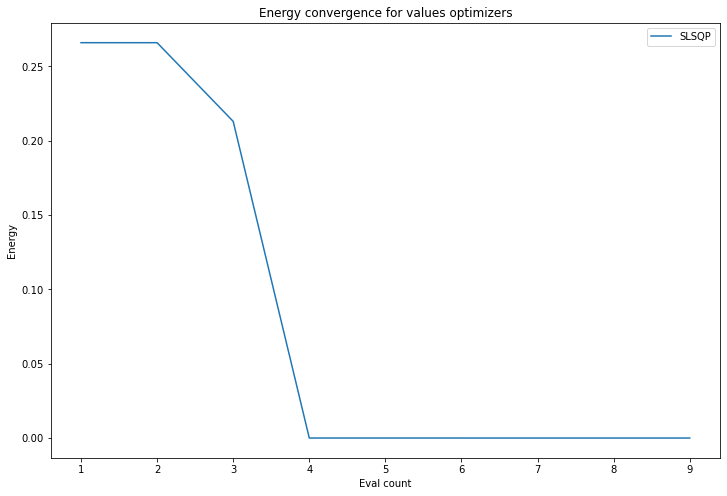

In [28]:
import pylab as pl
pl.rcParams['figure.figsize'] = (12, 8)
pl.plot(counts, values, label='SLSQP')
pl.xlabel('Eval count')
pl.ylabel('Energy')
pl.title('Energy convergence for values optimizers')
pl.legend(loc='upper right')

In [12]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [16]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    print(molecule.num_orbitals)
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    print(qubitOp.to_opflow())
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [17]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

6
SummedOp([
  -0.022557489516501213 * IIII,
  -0.1377203420784423 * IIIZ,
  0.0030814798575472526 * IIZX,
  -0.0030814798575472526 * IIIX,
  0.028730644705062643 * IIXX,
  -0.028730644705062643 * IIYY,
  -0.18587691299443093 * IIZZ,
  0.010290459664561795 * IIXZ,
  0.010290459664561795 * IIXI,
  0.4831838400304882 * IIZI,
  0.13772034207844225 * IZII,
  -0.003081479857547249 * ZXII,
  -0.003081479857547249 * IXII,
  0.028730644705062643 * XXII,
  -0.028730644705062643 * YYII,
  -0.185876912994431 * ZZII,
  -0.010290459664561796 * XZII,
  0.010290459664561796 * XIII,
  -0.4831838400304882 * ZIII,
  -0.10644519872260136 * IZIZ,
  0.009981252633645198 * IZZX,
  -0.009981252633645198 * IZIX,
  0.02785553952731284 * IZXX,
  -0.02785553952731284 * IZYY,
  0.009981252633645198 * IXIZ,
  0.009981252633645198 * ZXIZ,
  -0.0034841744099034866 * IXZX,
  -0.0034841744099034866 * ZXZX,
  0.0034841744099034866 * IXIX,
  0.0034841744099034866 * ZXIX,
  -0.006328347355474429 * IXXX,
  -0.006328347355

/Users/toshifumi.anan/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/qiskit/chemistry/components/initial_states/hartree_fock.py:61: DeprecationWarning: The HartreeFock class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits accept a plain QuantumCircuit. 
  super().__init__()
/Users/toshifumi.anan/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]


Interatomic Distance: 0.5 VQE Result: -7.039673441372131 Exact Energy: [-7.03973252]
6
SummedOp([
  -0.14805264965345397 * IIII,
  -0.1224014993629478 * IIIZ,
  0.0036260563519706335 * IIZX,
  -0.0036260563519706335 * IIIX,
  0.018567738562432906 * IIXX,
  -0.018567738562432906 * IIYY,
  -0.18723042971817513 * IIZZ,
  0.015093379357199238 * IIXZ,
  0.015093379357199238 * IIXI,
  0.42944468673737685 * IIZI,
  0.12240149936294778 * IZII,
  -0.003626056351970631 * ZXII,
  -0.003626056351970631 * IXII,
  0.01856773856243294 * XXII,
  -0.01856773856243294 * YYII,
  -0.1872304297181751 * ZZII,
  -0.015093379357199238 * XZII,
  0.015093379357199238 * XIII,
  -0.4294446867373769 * ZIII,
  -0.11742444308921923 * IZIZ,
  0.007813465716060721 * IZZX,
  -0.007813465716060721 * IZIX,
  0.034252847488629744 * IZXX,
  -0.034252847488629744 * IZYY,
  0.007813465716060721 * IXIZ,
  0.007813465716060721 * ZXIZ,
  -0.0024971469771747712 * IXZX,
  -0.0024971469771747712 * ZXZX,
  0.0024971469771747712 * I

Interatomic Distance: 0.8 VQE Result: -7.630945409564086 Exact Energy: [-7.63097825]
6
SummedOp([
  -0.24856837156134376 * IIII,
  -0.08833220380647187 * IIIZ,
  0.00047760205818942933 * IIZX,
  -0.00047760205818942933 * IIIX,
  0.004065229467884353 * IIXX,
  -0.004065229467884353 * IIYY,
  -0.1980422554893176 * IIZZ,
  0.020638324780023552 * IIXZ,
  0.020638324780023552 * IIXI,
  0.38843443559063784 * IIZI,
  0.08833220380647189 * IZII,
  -0.00047760205818943194 * ZXII,
  -0.00047760205818943194 * IXII,
  0.0040652294678843615 * XXII,
  -0.0040652294678843615 * YYII,
  -0.1980422554893176 * ZZII,
  -0.020638324780023552 * XZII,
  0.020638324780023552 * XIII,
  -0.38843443559063784 * ZIII,
  -0.13097539918608783 * IZIZ,
  0.009129289529645989 * IZZX,
  -0.009129289529645989 * IZIX,
  0.040357126775295175 * IZXX,
  -0.040357126775295175 * IZYY,
  0.009129289529645987 * IXIZ,
  0.009129289529645987 * ZXIZ,
  -0.002321628429995703 * IXZX,
  -0.002321628429995703 * ZXZX,
  0.00232162842999

Interatomic Distance: 1.1 VQE Result: -7.823568081160063 Exact Energy: [-7.82359928]
6
SummedOp([
  -0.20363020521747888 * IIII,
  -0.08548542698965861 * IIIZ,
  -0.0014443592317084902 * IIZX,
  0.0014443592317084902 * IIIX,
  0.0016780438053368694 * IIXX,
  -0.0016780438053368694 * IIYY,
  -0.20816831926855128 * IIZZ,
  0.02086534304564929 * IIXZ,
  0.02086534304564929 * IIXI,
  0.3951217558223078 * IIZI,
  0.08548542698965866 * IZII,
  0.0014443592317084923 * ZXII,
  0.0014443592317084923 * IXII,
  0.001678043805336892 * XXII,
  -0.001678043805336892 * YYII,
  -0.20816831926855137 * ZZII,
  -0.020865343045649302 * XZII,
  0.020865343045649302 * XIII,
  -0.39512175582230796 * ZIII,
  -0.1287192103431656 * IZIZ,
  0.010584233412386321 * IZZX,
  -0.010584233412386321 * IZIX,
  0.03764475672848792 * IZXX,
  -0.03764475672848792 * IZYY,
  0.01058423341238632 * IXIZ,
  0.01058423341238632 * ZXIZ,
  -0.002546265653215098 * IXZX,
  -0.002546265653215098 * ZXZX,
  0.002546265653215098 * IXIX,

Interatomic Distance: 1.4 VQE Result: -7.876966254831255 Exact Energy: [-7.87700149]
6
SummedOp([
  -0.19975412837028855 * IIII,
  -0.09179660692474548 * IIIZ,
  -0.0027341075111981905 * IIZX,
  0.0027341075111981905 * IIIX,
  -0.000309895034674006 * IIXX,
  0.000309895034674006 * IIYY,
  -0.2119593401712062 * IIZZ,
  0.01957765384258227 * IIXZ,
  0.01957765384258227 * IIXI,
  0.37135640377239365 * IIZI,
  0.0917966069247455 * IZII,
  0.002734107511198182 * ZXII,
  0.002734107511198182 * IXII,
  -0.0003098950346740112 * XXII,
  0.0003098950346740112 * YYII,
  -0.21195934017120624 * ZZII,
  -0.019577653842582275 * XZII,
  0.019577653842582275 * XIII,
  -0.3713564037723936 * ZIII,
  -0.12357087224901454 * IZIZ,
  0.011733623912011604 * IZZX,
  -0.011733623912011604 * IZIX,
  0.033058728587779196 * IZXX,
  -0.033058728587779196 * IZYY,
  0.011733623912011605 * IXIZ,
  0.011733623912011605 * ZXIZ,
  -0.003034656830178101 * IXZX,
  -0.003034656830178101 * ZXZX,
  0.003034656830178101 * IXIX

Interatomic Distance: 1.7 VQE Result: -7.878236970433214 Exact Energy: [-7.87826817]
6
SummedOp([
  -0.22801530025392908 * IIII,
  -0.09688811186719734 * IIIZ,
  -0.004160423678165894 * IIZX,
  0.004160423678165894 * IIIX,
  -0.0033583011381291003 * IIXX,
  0.0033583011381291003 * IIYY,
  -0.20910087963072288 * IIZZ,
  0.018712422135144003 * IIXZ,
  0.018712422135144003 * IIXI,
  0.32924869973628534 * IIZI,
  0.09688811186719731 * IZII,
  0.004160423678165897 * ZXII,
  0.004160423678165897 * IXII,
  -0.003358301138129109 * XXII,
  0.003358301138129109 * YYII,
  -0.20910087963072288 * ZZII,
  -0.018712422135144006 * XZII,
  0.018712422135144006 * XIII,
  -0.32924869973628534 * ZIII,
  -0.11840332893023431 * IZIZ,
  0.01304943599933303 * IZZX,
  -0.01304943599933303 * IZIX,
  0.029465573707158264 * IZXX,
  -0.029465573707158264 * IZYY,
  0.01304943599933303 * IXIZ,
  0.01304943599933303 * ZXIZ,
  -0.0038566832861855202 * IXZX,
  -0.0038566832861855202 * ZXZX,
  0.0038566832861855202 * IX

Interatomic Distance: 2.0 VQE Result: -7.860068379562771 Exact Energy: [-7.86015321]
6
SummedOp([
  -0.2566131031143751 * IIII,
  -0.09977217483143819 * IIIZ,
  -0.005941820763532316 * IIZX,
  0.005941820763532316 * IIIX,
  -0.006639110314036634 * IIXX,
  0.006639110314036634 * IIYY,
  -0.20221910425699885 * IIZZ,
  0.018696122180522332 * IIXZ,
  0.018696122180522332 * IIXI,
  0.28813304879442825 * IIZI,
  0.09977217483143822 * IZII,
  0.005941820763532314 * ZXII,
  0.005941820763532314 * IXII,
  -0.006639110314036644 * XXII,
  0.006639110314036644 * YYII,
  -0.20221910425699885 * ZZII,
  -0.018696122180522343 * XZII,
  0.018696122180522343 * XIII,
  -0.2881330487944282 * ZIII,
  -0.11343979132343963 * IZIZ,
  0.014650040221303786 * IZZX,
  -0.014650040221303786 * IZIX,
  0.02723541954162076 * IZXX,
  -0.02723541954162076 * IZYY,
  0.014650040221303782 * IXIZ,
  0.014650040221303782 * ZXIZ,
  -0.005151269440855072 * IXZX,
  -0.005151269440855072 * ZXZX,
  0.005151269440855072 * IXIX,
 

Interatomic Distance: 2.3 VQE Result: -7.837212702606242 Exact Energy: [-7.83725797]
6
SummedOp([
  -0.2755825112142727 * IIII,
  -0.10126096889927313 * IIIZ,
  -0.008177765542693009 * IIZX,
  0.008177765542693009 * IIIX,
  -0.009619557713871824 * IIXX,
  0.009619557713871824 * IIYY,
  -0.19331934647346727 * IIZZ,
  0.019410628507122274 * IIXZ,
  0.019410628507122274 * IIXI,
  0.2544764434713801 * IIZI,
  0.10126096889927311 * IZII,
  0.008177765542693017 * ZXII,
  0.008177765542693017 * IXII,
  -0.009619557713871837 * XXII,
  0.009619557713871837 * YYII,
  -0.19331934647346727 * ZZII,
  -0.019410628507122284 * XZII,
  0.019410628507122284 * XIII,
  -0.2544764434713801 * ZIII,
  -0.10872637258298194 * IZIZ,
  0.016652963253121083 * IZZX,
  -0.016652963253121083 * IZIX,
  0.025830832624264215 * IZXX,
  -0.025830832624264215 * IZYY,
  0.016652963253121083 * IXIZ,
  0.016652963253121083 * ZXIZ,
  -0.007173725773596456 * IXZX,
  -0.007173725773596456 * ZXZX,
  0.007173725773596456 * IXIX,


KeyboardInterrupt: 

In [22]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
geometry = [["Be", [2.5369, 0.155, 0]], ["H", [2, -0.155, 0]], ["H", [3.0739, -0.155, 0]]]
# geometry = [['H', [0., 0., 0.]], ['H', [0., 0., 0.735]]]
molecule = Molecule(geometry=geometry,
                     charge=0, multiplicity=1)

driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

In [23]:
from qiskit.chemistry.transformations import (FermionicTransformation,
                                              FermionicTransformationType,
                                              FermionicQubitMappingType)

fermionic_transformation = FermionicTransformation(
            transformation=FermionicTransformationType.FULL,
            qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER,
            two_qubit_reduction=False,
            freeze_core=False)

In [24]:
qubit_op, _ = fermionic_transformation.transform(driver)
print(qubit_op)
print(fermionic_transformation.molecule_info)

SummedOp([
  -13.924079423970618 * IIIIIIIIIIIIII,
  2.4582531356834987 * IIIIIIIIIIIIIZ,
  0.06009433672525737 * IIIIIIIIIIIIYY,
  0.06009433672525737 * IIIIIIIIIIIIXX,
  -1.357822960504549e-05 * IIIIIIIIIIIYZY,
  -1.357822960504549e-05 * IIIIIIIIIIIXZX,
  0.019438253429563825 * IIIIIIIIIIYZZY,
  0.019438253429563825 * IIIIIIIIIIXZZX,
  -0.056882081442064275 * IIIIIIIIYZZZZY,
  -0.056882081442064275 * IIIIIIIIXZZZZX,
  1.1723928795012793e-05 * IIIIIIIYZZZZZY,
  1.1723928795012793e-05 * IIIIIIIXZZZZZX,
  0.12320357254914716 * IIIIIIIIIIIIZI,
  8.726982948349078e-06 * IIIIIIIIIIIYYI,
  8.726982948349078e-06 * IIIIIIIIIIIXXI,
  0.010176911829161538 * IIIIIIIIIIYZYI,
  0.010176911829161538 * IIIIIIIIIIXZXI,
  0.02891691768128688 * IIIIIIIIYZZZYI,
  0.02891691768128688 * IIIIIIIIXZZZXI,
  -8.060088696687935e-06 * IIIIIIIYZZZZYI,
  -8.060088696687935e-06 * IIIIIIIXZZZZXI,
  0.06513751358640604 * IIIIIIIIIIIZII,
  -2.5819887900763696e-06 * IIIIIIIIIIYYII,
  -2.5819887900763696e-06 * IIIIIIII

In [34]:
fermionic_transformation_2 = FermionicTransformation(
            transformation=FermionicTransformationType.PARTICLE_HOLE,
            qubit_mapping=FermionicQubitMappingType.PARITY,
            two_qubit_reduction=True,
            freeze_core=True,
            orbital_reduction=[-3, -2],
            z2symmetry_reduction='auto')
qubit_op_2, _ = fermionic_transformation_2.transform(driver)
print(qubit_op_2)

SummedOp([
  1.954094489892838 * IIIIII,
  0.22058769694763694 * IIIIIZ,
  -2.0665330466016804e-06 * IIIIZX,
  2.0665330466016804e-06 * IIIIIX,
  -0.027405890478209658 * IIIZXX,
  -0.027405890478209658 * IIIIYY,
  -3.993070097519908e-06 * IIIXXX,
  -3.993070097519908e-06 * IIIYXY,
  0.18022817537935115 * IIIIZZ,
  4.6878164110579e-06 * IIIZXZ,
  -4.6878164110579e-06 * IIIIXI,
  -0.035141541187728775 * IIIXXZ,
  -0.035141541187728775 * IIIYYI,
  0.024160976649857883 * IIIZZI,
  -1.180672609613805e-06 * IIIXZI,
  1.180672609613805e-06 * IIIXII,
  -0.43983479075861637 * IIIZII,
  0.22058769694763694 * IIZIII,
  -2.06653304660168e-06 * IZXIII,
  2.06653304660168e-06 * IIXIII,
  -0.02740589047820965 * ZXXIII,
  -0.02740589047820965 * IYYIII,
  -3.99307009751991e-06 * XXXIII,
  -3.99307009751991e-06 * YXYIII,
  0.1802281753793514 * IZZIII,
  4.687816411057903e-06 * ZXZIII,
  -4.687816411057903e-06 * IXIIII,
  -0.0351415411877288 * XXZIII,
  -0.0351415411877288 * YYIIII,
  0.02416097664985788